In [1]:
## from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pandas as pd
import numpy as np
import scipy.optimize
import re
import os
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter


import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot
from trmc.plot import exp_formatter

import xarray as xr

mpl.rcParams['figure.figsize'] = [8, 8]
mpl.rc('font',**{'size' : 18})

from IPython.display import clear_output

import itertools

from collections import OrderedDict

import easygui

In [29]:
basedir = '\\\\depot.engr.oregonstate.edu\\users\\coe_apirate\\Windows.Documents\\Desktop\\Data'
fps = {
    'A': os.path.join(basedir,'20190128\Bi_A_2'),
    'C': os.path.join(basedir,'20190130\Sample Bi_C_2_2')
}

In [30]:
da_sw = load.sweeps2ds(fps)['Vsignal(V)']

In [6]:


das = []
das_bv = []

for samp in fps:
    direc = os.path.join(fps[samp],'FreqFluence')
    print('Loading data for ' + samp)
    s_fps = load.freqfluence_flist(direc)
#     print(s_fps)
    s,backvs = load.freqfluence_load(s_fps)
    print('Converting to Dataset')
    da = xr.DataArray.from_series(s)
    da = da.expand_dims('sample')
    da['sample'] = [samp]
    das.append(da)
    
    da_bv = xr.DataArray.from_series(backvs)
    da_bv = da_bv.expand_dims('sample')
    da_bv['sample'] = [samp]
    das_bv.append(da_bv)
    
da_dv = xr.concat(das, dim = 'sample')
da_dv = da_dv*(-1) #voltage is flipped
da_bv = xr.concat(das_bv,dim = 'sample')
print('done')

no match for file TestSweep_psm_image.png
Converting to Dataset
done


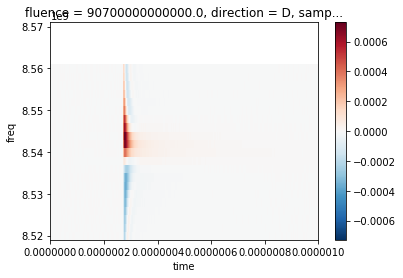

In [224]:
da_dv.sel(sample = 'C').dropna('fluence','all').isel(fluence = 7).sel(direction = 'D').plot()

In [35]:

das = []
for samp in fps:
    direc = os.path.join(fps[samp],'FreqFluence')    
    fpsdcs = load.freqdcs_flist(direc)
    
    for direction,freqt in fpsdcs.index:
        fp = fpsdcs.loc[direction,freqt]
        s = load.loadsweep(fp,defaultV = 0.025)
        s = s.rename(s.name.replace(' ', ''))
        s.index = s.index.rename('freq')
        da = xr.DataArray.from_series(s)
        da = da.assign_coords(direction = direction).expand_dims('direction')
        da = da.assign_coords(freqt = freqt).expand_dims('freqt')
        da = da.assign_coords(sample = samp).expand_dims('sample')
        das.append(da)
    
da_dcs = xr.merge(das)['Vsignal(V)']

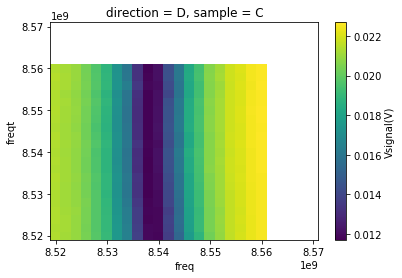

In [42]:
da_dcs.sel(sample = 'C').sel(direction = 'D').plot()

In [62]:
da_dcs.indexes['sample']

Index(['A', 'C'], dtype='object', name='sample')

A
C


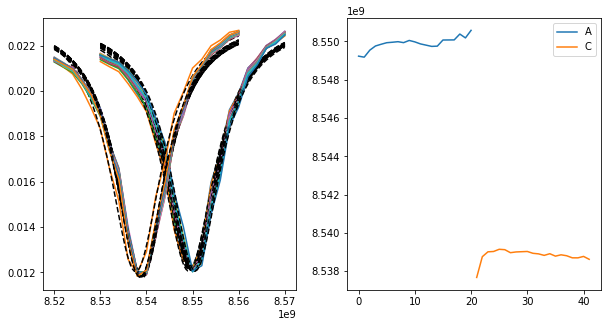

In [100]:

p_labels = ['f0','w','R','Rinf'] 
epsilon = 0.00001
bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
window = 100



fig, axes = plt.subplots(1,2, figsize = (10,5))

daf0s = []
for samp in da_dcs.indexes['sample']:
    print(samp)
    da = da_dcs.sel(sample = samp).sel(direction = 'U').dropna('freq','all').dropna('freqt','all')
    f0s = []
    for freqt in da.indexes['freqt']:
        d = da.sel(freqt = freqt)
        axes[0].plot(d.to_series())

        Rinf = 0.02125
        f0 = d.to_series().idxmin()
        p0 =[f0,1e7,0.01, Rinf]

        v0_fit, v0_p,v0_sl = analysis.fitsweep(d, p0, bounds, window , 'lor',p_labels)
        f0s.append(v0_p[0])

        freqs = da.indexes['freq']
        freqs_i = np.linspace(freqs.min(),freqs.max(),100)
        dfit = v0_fit(freqs_i)
        dfit = pd.Series(dfit, index = freqs_i)
        axes[0].plot(dfit, color = 'black', linestyle = '--')
    
    daf0s.append(xr.DataArray(f0s, coords = {'freqt' : da.indexes['freqt']}, dims= ['freqt']).assign_coords(sample = samp).expand_dims('sample'))


daf0s = xr.concat(daf0s, dim = 'freqt')

for samp in daf0s.indexes['sample']:
    axes[1].plot(daf0s.sel(sample = samp), label = samp)
    
axes[1].legend()

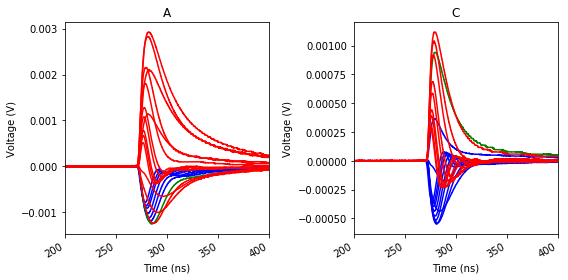

In [122]:
def redbluetransient(data,ax):
    freqs = data.indexes['freq']
    labeledblue = False
    labeledred = False
    for freq in freqs:
        if freq < 8.542e9:
            color = 'b'
            if labeledblue:
                label = None
            else:
                label = 'Frequency Below Resonance'
                labeledblue = True
        elif freq > 8.542e9:
            color = 'r'
            if labeledred:
                label = None
            else:
                label = 'Frequency Above Resonance'
                labeledred = True
        elif freq == 8.542e9:
            color = 'g'
            label = 'On resonance'
        trace = data.sel(freq = freq)
        ax.plot(trace.to_series(), color = color, label = label)

    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

    # ax.set_xlim(200e-9,400e-9)
    # ax.set_ylim([-0.002,0.002])
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Voltage (V)')
    
size = len(da_dv.indexes['sample'])
fig, axes = plt.subplots(1,size, figsize = (4*size, 2*size))

for i,samp in enumerate(da_dv.indexes['sample']):
    data = da_dv.sel(sample = samp).sel(direction = 'U').dropna('fluence','all').isel(fluence = -1)
    ax = axes[i]
    redbluetransient(data,ax)
    ax.set_title(samp)
    ax.set_xlim([200e-9,400e-9])


# ax.legend()
fig.autofmt_xdate()
fig.tight_layout()

In [154]:
# For partial data sets, cut down the dark cavity sweep

fmin = da_dv.indexes['freq'].min()
fmax = da_dv.indexes['freq'].max()

idxmin = abs(da_dcs.indexes['freq'] - fmin).argmin()
idxmax = abs(da_dcs.indexes['freq'] - fmax).argmin() + 1 #???

v0 = da_dcs.isel(freq = slice(idxmin,idxmax)).sel(direction = 'U').isel(freqt = 5)
# v0 = da_dcs.sel(direction = 'U').isel(freqt = 0)

v0

<xarray.DataArray 'Vsignal(V)' (sample: 2, freq: 26)>
array([[     nan,      nan,      nan,      nan,      nan, 0.02148 , 0.021192,
        0.021032, 0.020496, 0.019857, 0.019227, 0.017858, 0.016595, 0.014029,
        0.012659, 0.012253, 0.013272, 0.015968, 0.017226, 0.019169, 0.019907,
        0.021011, 0.021397, 0.021925, 0.022129, 0.022496],
       [0.021356, 0.021145, 0.021052, 0.020419, 0.01979 , 0.01907 , 0.017618,
        0.016549, 0.014036, 0.012039, 0.01193 , 0.013607, 0.015347, 0.017852,
        0.018933, 0.020307, 0.020909, 0.021635, 0.021919, 0.022321, 0.022483,
             nan,      nan,      nan,      nan,      nan]])
Coordinates:
    direction  <U1 'U'
  * freq       (freq) int64 8520000000 8522000000 ... 8568000000 8570000000
    freqt      float64 8.53e+09
  * sample     (sample) object 'A' 'C'

In [159]:
v0s = v0.interp(freq = da_dv.indexes['freq'])

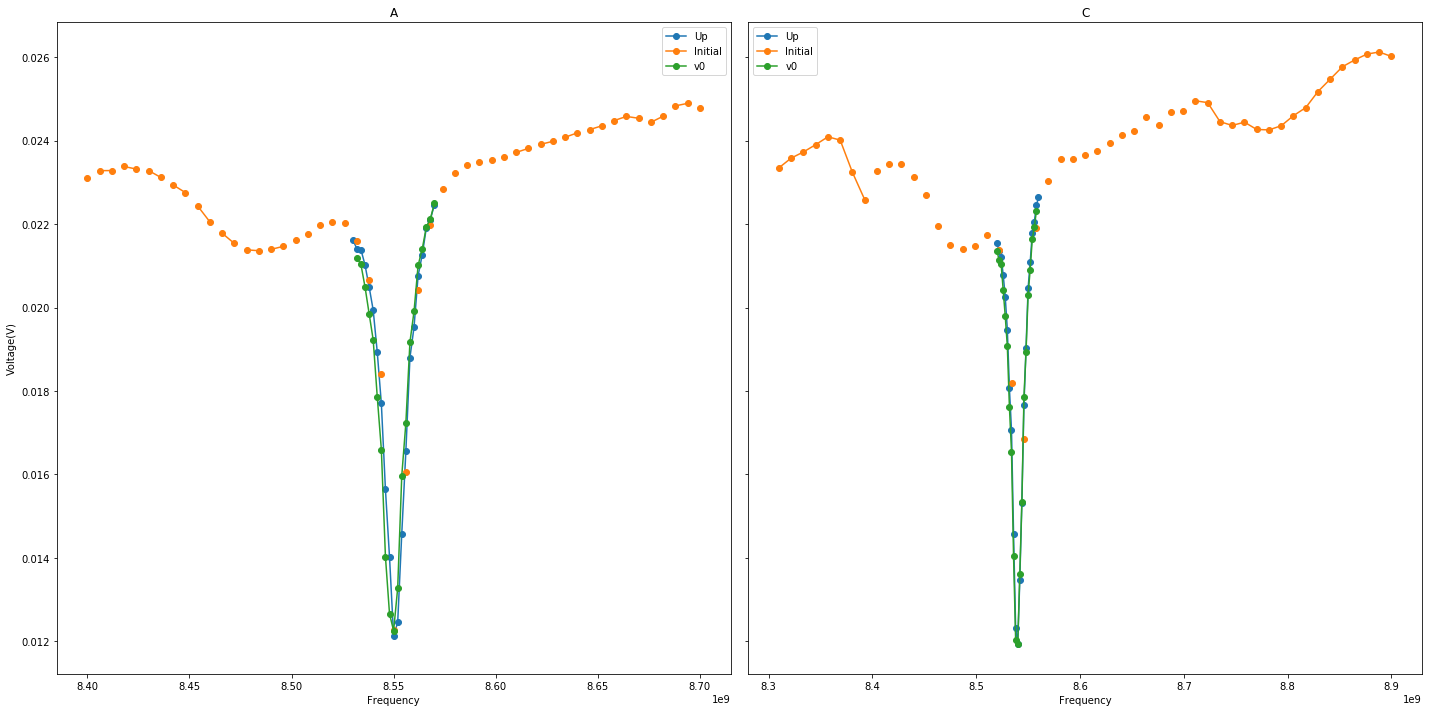

In [168]:
samples = da_bv.indexes['sample']
size = len(samples)
fig, axes = plt.subplots(1,size, figsize = (10*size,5*size) , sharey = True, squeeze=False)



for i, samp in enumerate(samples):
    swp_bv_u = da_bv.sel(sample = samp, direction = 'U').dropna(dim = 'freq')
    axes[0][i].plot(swp_bv_u.indexes['freq'],swp_bv_u,marker = 'o', label = 'Up')
#     swp_bv_d = da_bv.sel(sample = samp, direction = 'D').dropna(dim = 'freq')
#     ax.plot(swp_bv_d.indexes['freq'],swp_bv_d,marker = 'o', label = 'Down')
    swp_init = da_sw.sel(sample = samp, tc = '_1_', swtime = 0)
    axes[0][i].plot(swp_init.indexes['freq'],swp_init,marker = 'o',label = 'Initial')
    v0= v0s.sel(sample = samp).dropna('freq')
    axes[0][i].plot(v0.to_series(),marker = 'o',label = 'v0')
    axes[0][i].set_title(samp)
    axes[0][i].legend()
    axes[0][i].set_xlabel('Frequency')
    axes[0][0].set_ylabel('Voltage(V)') 

    fig.tight_layout()

In [169]:
fittype = 'lor'
# fittype = 'poly'

if fittype == 'lor':
    Rinf = 0.02125
    f0 = 8.555e9
    p0 =[f0,1e7,0.01, Rinf]
    p_labels = ['f0','w','R','Rinf'] 
    epsilon = 0.00001
#     bounds = ([0,0,0, Rinf - epsilon],[np.inf,np.inf,np.inf, Rinf + epsilon])
    bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf, np.inf])
    window = 100

elif fittype == 'poly':
    window = 2
    p_labels = ['R', 'f0', 'p0','p1','p2']
    bounds = ([-np.inf,-np.inf,-np.inf],[np.inf,np.inf,np.inf])
    p0 = [.01,1e-9,1e-18]


In [170]:
da_p = da_dv.isel(freq = 0).drop('freq').where(False).copy()
da_p0 = da_sw.sel(tc = '_2_',swtime = 0).isel(freq = 0).drop('tc').drop('swtime').drop('freq').where(False).copy()

da_p_dict = {}
da_p0_dict = {}
for p in p_labels:
    da_p_dict[p] = da_p
    da_p0_dict[p] = da_p0
    
#Not exactly sure why I have to do this copying. Otherwise I think the reference to the original numpy array is kept and assignments get all weird
ds_p = xr.Dataset(da_p_dict).copy(deep=True)
ds_p0 = xr.Dataset(da_p0_dict).copy(deep=True)


K sample A = 71598.46093651639
K sample C = 76863.11438014379


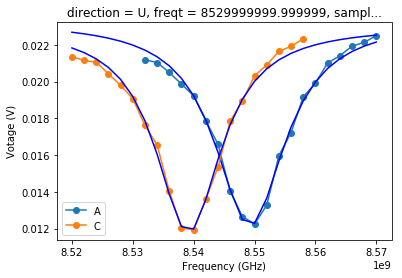

In [174]:
v0_fits = v0s.copy()

samples = v0s.indexes['sample']
freqs_i = da_dv.indexes['freq']
mi = pd.MultiIndex.from_product([samples,freqs_i], names = ['sample', 'freq'])
s = pd.Series(index = mi)
v0s_i = xr.DataArray.from_series(s)

Ks = pd.Series(index = samples)
for samp in v0s.indexes['sample']:
    v0 = v0s.sel(sample = samp).dropna('freq','all')
    
    dv = da_dv.sel(sample = samp, direction = 'U', time = 0).dropna(dim = 'fluence', how = 'all').isel(fluence = -1).dropna(dim = 'freq')
    freqs = dv.indexes['freq']
    
    v0s_i.loc[samp] = v0.interp(freq = freqs).reindex(freq = freqs_i)
    f0 = v0.to_series().idxmin()
    p0[0] = f0
    
    v0_fit, v0_p,v0_sl = analysis.fitsweep(v0, p0, bounds, window , fittype,p_labels)
    freqs = v0s.indexes['freq'][v0_sl]
    v0_fits.loc[samp] = v0_fit(freqs)
    
    v0s_i.loc[samp].plot(marker = 'o', label = samp)
    v0_fits.loc[samp].plot(color = 'b')
    
    for i, p in enumerate(ds_p0.data_vars):
        ds_p0[p].loc[samp] = v0_p[i]
    
    Ks[samp] = analysis.calc_K(f0 = v0_p[0], w = v0_p[1], R0 = v0_p[2]/v0_p[3], printparams = False)
    print('K sample ' + samp + ' = ' + str(Ks.loc[samp]))
plt.xlabel('Frequency (GHz)')
plt.ylabel('Votage (V)')
plt.legend()

In [206]:
time1 = 250e-9
time2 = 400e-9
step = 50

times = da_dv.indexes['time']
timesel1 = pd.Series(abs(times-time1)).idxmin()
timesel2 = pd.Series(abs(times-time2)).idxmin()

times = times[slice(timesel1,timesel2,step)]

In [225]:
ds_p_r  =  ds_p.sel(direction = 'D').drop(['direction']).sel(time = times).copy(deep = True)
dvs = da_dv.sel( direction = 'D').dropna(dim = 'freq', how = 'all').sel(time = times)

# dvs
vss = v0s + dvs
fits = vss.copy(deep = True)

cds = ds_p_r.coords

num = len(cds['fluence'])*len(cds['sample'])*len(cds['time'])
i=0

for samp in vss.indexes['sample']:
    vs1 = vss.sel(sample = samp).dropna('fluence','all')   
    for flu in vs1.indexes['fluence']:
        vs2 = vs1.sel(fluence = flu).dropna('time','all')
        for time in vs2.indexes['time']:
            i=i+1
            clear_output(wait = True)
            print(str((i/num)*300) + ' %') #Not sure where this factor of 3 is coming from, see num above. 
            
            vs3 = vs2.sel(time = time).dropna('freq')
            f0 = vs3.to_series().idxmin()
            p0[0] = f0
            
            vs_fit, vs_p,vs_sl = analysis.fitsweep(vs3, p0, bounds, window , fittype,p_labels)

            freqs = vs2.indexes['freq'][vs_sl]
            fits.loc[samp,:,flu,time] = vs_fit(freqs).values
            ds_p_r['f0'].loc[samp,flu,time] = vs_p[0]
            ds_p_r['w'].loc[samp,flu,time] = vs_p[1]
            ds_p_r['R'].loc[samp,flu,time] = vs_p[2]
            ds_p_r['Rinf'].loc[samp,flu,time] = vs_p[3]
                    
fits.name = 'fits'
dvs.name = 'dvs'
vss.name = 'vss'
            
das = [dvs,fits,vss]
ds = xr.merge(das)

150.0 %


In [226]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

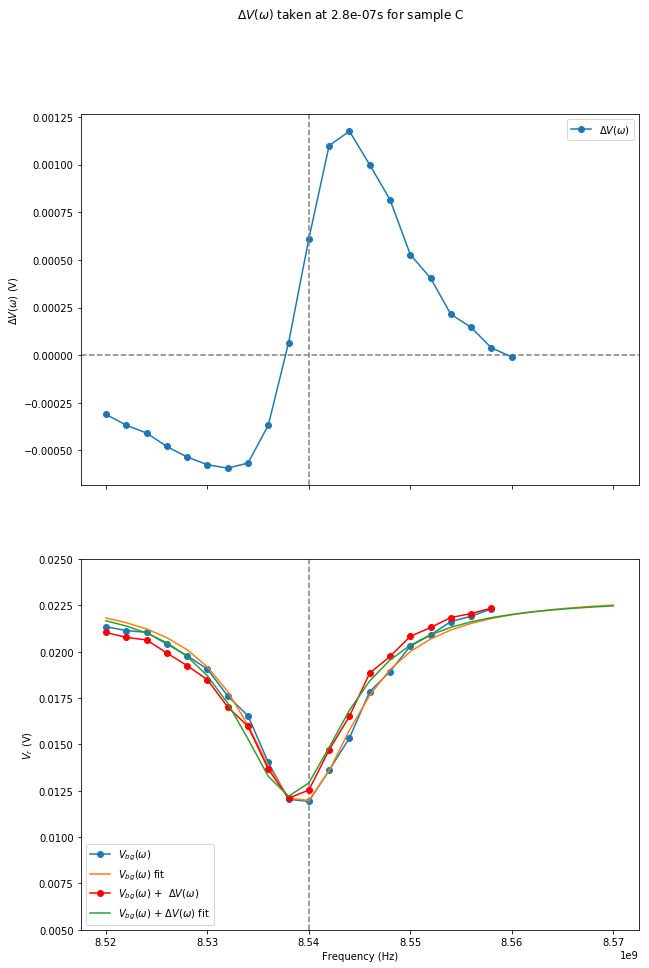

In [230]:


samp = 'C'

dst = ds.sel(sample = samp).dropna('fluence','all').isel(fluence = -1)
v0 = v0s_i.sel(sample = samp)

def inter_vsplot(time):
    fig, axes = plot.vsplotxr(time, dst['dvs'], vss= dst['vss'], fits = dst['fits'], v0 = v0, v0_fit = v0_fits.loc[samp])

    axes[1].set_ylim([0.005,0.025])
    for ax in axes:
        ax.legend()
        
interact(inter_vsplot, time=280);

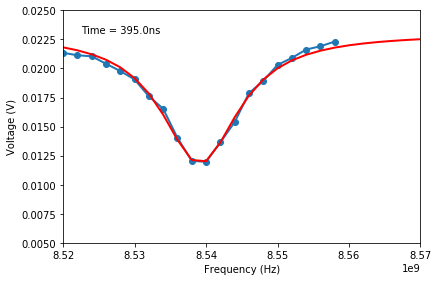

In [231]:
plot.sweepfitanim(dst, interval = 100)

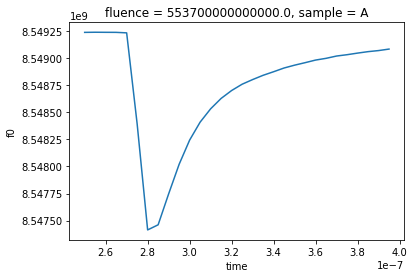

In [228]:
ds_p_r.sel(sample = 'A').dropna('fluence','all').isel(fluence = -1)['f0'].plot()

C:\Users\coe_apirate\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\matplotlib\ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


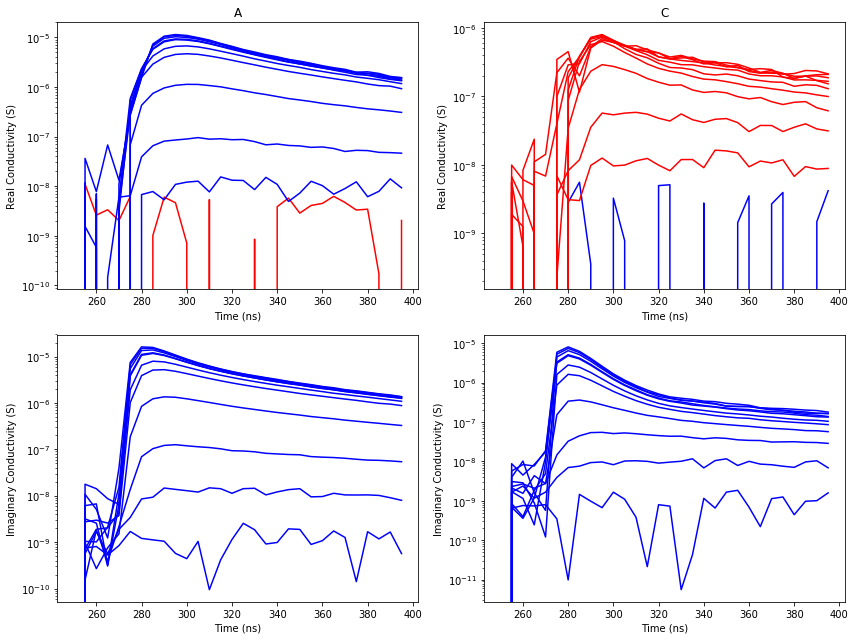

In [232]:
fig, axes = plt.subplots(2,len(ds.indexes['sample']), figsize = (12,9), squeeze = False)
# axes= [axes]
e0 = 8.854e-12
F=1

ft = ds_p_r['f0']
f0 = ft.isel(time = 0)
deltaf = abs(ft-f0)
sig_I_a = -1*deltaf*e0/F

wt = ds_p_r['w']
w0 = wt.isel(time = 0)
deltaFWHM = wt - w0
sig_R_a = deltaFWHM*e0/(2*F)


for i , samp in enumerate(ds_p_r.indexes['sample']):
    sig_Rs = sig_R_a.sel(sample = samp).dropna('fluence','all').copy(deep = True)
    sig_Is = sig_I_a.sel(sample = samp).dropna('fluence','all').copy(deep = True)
    for fluence in sig_Rs.indexes['fluence']:
        sig_R = sig_Rs.sel(fluence = fluence)
        sig_I = sig_Is.sel(fluence = fluence)

        label = '$\sigma^{\'}(\Delta FWHM)$'

        ax = axes[0][i]
        sig_R = sig_R.to_series()
        if np.trapz(sig_R) < 0:
            color = 'b'
            sig_R = sig_R*-1
        else:
            color = 'r'
        ax.plot(sig_R, label = label, color = color)
        ax.set_yscale('log')
        ax.set_ylabel('Real Conductivity (S)')

        ax = axes[1][i]
        sig_I = sig_I.to_series()
        if np.trapz(sig_I) < 0:
            color = 'b'
            sig_I = sig_I*-1
        else:
            color = 'r'
        ax.plot(sig_I, label = '$\sigma^{\'\'}(\Delta\omega)$', color = color)
        ax.set_yscale('log')
        ax.set_ylabel('Imaginary Conductivity (S)')

    ax = axes[0][i]
    ax.set_title(samp)
for axs in axes:
    for ax in axs:
    #     for ax in axs:
        ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    #         axes.set_xlim(250e-9,1200e-9)
        ax.set_xlabel('Time (ns)')

        # axes.set_ylim([1e-8,1e-4])

fig.tight_layout()

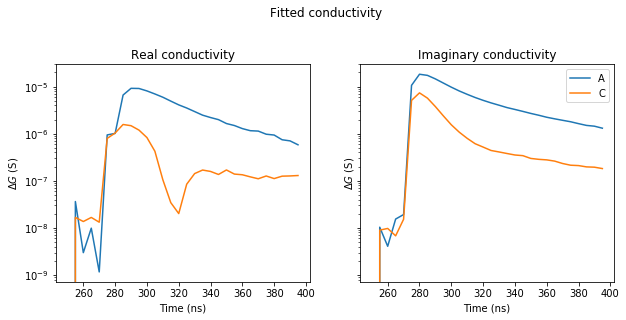

In [213]:
# res = g.sel(freq = 8.5420e9, method = 'nearest')

fig, axes = plt.subplots(1,2, figsize = (10,4), sharey = True)

for sample in ds.indexes['sample']:
    sel = sig_R_a.sel(sample = sample).dropna('fluence','all').isel(fluence = -1)
    axes[0].plot(abs(sel.to_series()), label = sample)
    axes[0].set_title('Real conductivity')
    sel = sig_I_a.sel(sample = sample).dropna('fluence','all').isel(fluence = -1)
    axes[1].plot(abs(sel.to_series()), label = sample)
    axes[1].set_title('Imaginary conductivity')

for ax in axes:
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('$\Delta G$ (S)')
        
        
fig.suptitle('Fitted conductivity', y = 1.08)
ax.legend()

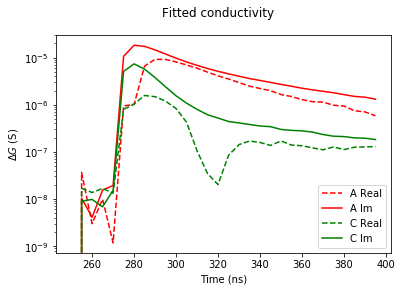

In [214]:
# res = g.sel(freq = 8.5420e9, method = 'nearest')

fig, ax = plt.subplots()

colors = ['r','g','b']

for i, sample in enumerate(ds.indexes['sample']):
    sigr = sig_R_a.sel(sample = sample).dropna('fluence','all').isel(fluence = -1)
    sigi = sig_I_a.sel(sample = sample).dropna('fluence','all').isel(fluence = -1)
    ax.plot(abs(sigr.to_series()), label = sample + " Real", linestyle = '--', color = colors[i])
    ax.plot(abs(sigi.to_series()), label = sample + " Im", color = colors[i])    
    ax.set_yscale('log')
    ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))
        
ax.set_xlabel('Time (ns)')
ax.set_ylabel('$\Delta G$ (S)')
        
fig.suptitle('Fitted conductivity')
ax.legend()